In [5]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import os
from helpers.datasets import *
from helpers.plotting import *
from sklearn.model_selection import train_test_split


plt.style.use("science.mplstyle")

from matplotlib.backends.backend_pdf import PdfPages as pp

np.random.seed(8)

In [6]:
# directories
feta_dir = "/global/home/users/rrmastandrea/FETA/"

# function input paramters
n_points = 100000
dataset_id = "triangle"
n_features = 2 # including context
dataset_config_string = f"{dataset_id}_npoints{n_points}_nfeatures{n_features}/"

# make directory for data
data_dir = os.path.join(feta_dir, dataset_config_string, "data")
print("Making dataset directory at", data_dir, "...")
os.makedirs(data_dir, exist_ok=True)

# make directory for plots
plots_dir = os.path.join(feta_dir, "paper_plots")
print("Making plots directory at", plots_dir, "...")
os.makedirs(plots_dir, exist_ok=True)

Making dataset directory at /global/home/users/rrmastandrea/FETA/triangle_npoints100000_nfeatures2/data ...
Making plots directory at /global/home/users/rrmastandrea/FETA/paper_plots ...


In [7]:
# dataset generation parameters
context_endpoints = (0, 1)

bands_dict = {
              "sb1": [0, .34],
              "sr" : [.34, .66],
              "sb2": [.66, 1],
            }

print("Generating datasets...")

data_sim = make_dataset_with_context(n_points, n_features-1, dataset_id, context_endpoints, .999)
data_dat = make_dataset_with_context(n_points, n_features-1, dataset_id, context_endpoints, 1.001)

# Shift all the DAT samples by 0.5
data_dat[:,0] #+= 0.5

print("SIM shape:", data_sim.shape)
print("DAT shape:", data_dat.shape)

Generating datasets...
SIM shape: (100000, 2)
DAT shape: (100000, 2)


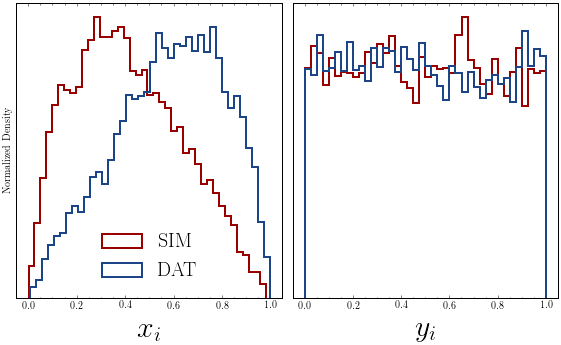

In [8]:
# features plots

dpi = 800

alpha = 0.5
n_plot = 10000
bins = 40

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1 #set the value globally

feature_labels = [r"$x_i$", r"$y_i$"]


n_features = 2
fig = plot_feature_histograms(data_sim, data_dat, bins, n_features, feature_labels, n_plot = n_plot)
fig.savefig(f"{plots_dir}/toy_features.pdf", dpi = dpi)
fig.show()

## Helper functions to process the data into bands

In [9]:
def pull_from_mass_range(dataset, mass_ranges):

        """
        mass_ranges is a list of lists [low_bound, high_bound]
        """

        selected_data = []

        for mass_range in mass_ranges:
            loc = np.where((dataset[:, -1] >= mass_range[0]) & (dataset[:, -1] < mass_range[1]))[0]
            selected_data.append( dataset[loc, :] )
        selected_data = np.concatenate(selected_data)
        np.random.shuffle(selected_data)

        return selected_data
    
    
def minmaxscale(data, col_minmax, lower = -3.0, upper = 3.0):
        
       
        minmaxscaled_data = np.zeros(data.shape)
        for col in range(data.shape[1]):

            X_std = (data[:, col] - col_minmax[col][0]) / (col_minmax[col][1] - col_minmax[col][0])
            minmaxscaled_data[:, col] = X_std * (upper - lower) + lower
        
        return minmaxscaled_data
     
# and get and store the column rescales (min and max of each feature)

col_minmax = []
for col in range(2):
    col_minmax.append([np.min(data_sim[:, col]), np.max(data_sim[:, col])])

np.save(os.path.join(data_dir, "col_minmax.npy"), col_minmax)


## Plot the full dataset

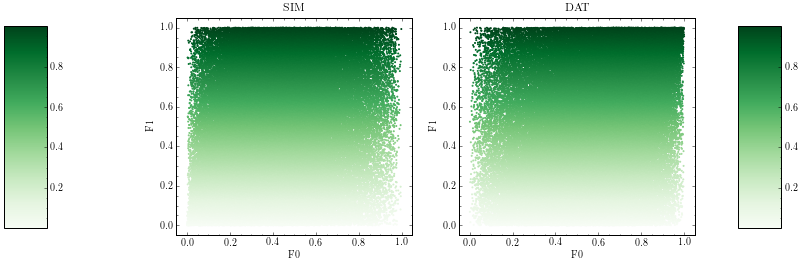

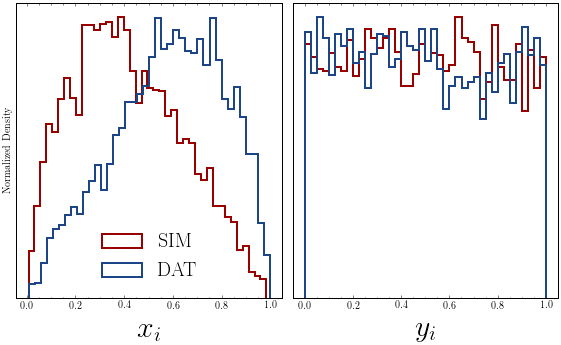

In [10]:
n_plot = 5000
bins = 40

# Scatterplot the features
fig = scatterplot_features(data_sim, data_dat, bins, n_features, feature_labels, n_plot = -1, pointsize = 1)
fig.show()

# 1D histograms of all the features
fig = plot_feature_histograms(data_sim, data_dat, bins, n_features, feature_labels, n_plot = n_plot)
fig.show()



## Plot specific bands

sb1
SIM sb1 shape: (34172, 2)
DAT sb1 shape: (34221, 2)
sr
SIM sr shape: (32084, 2)
DAT sr shape: (31998, 2)
sb2
SIM sb2 shape: (33744, 2)
DAT sb2 shape: (33781, 2)


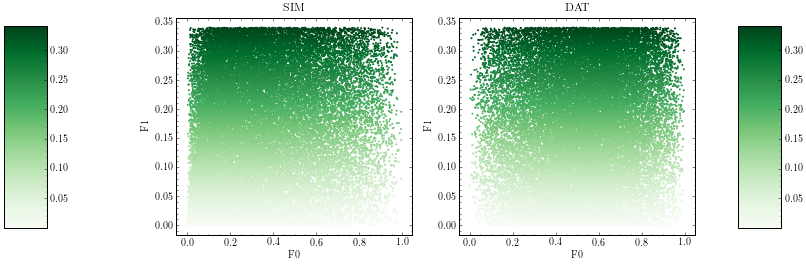

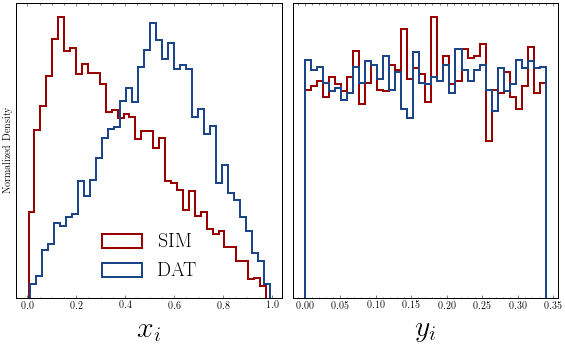

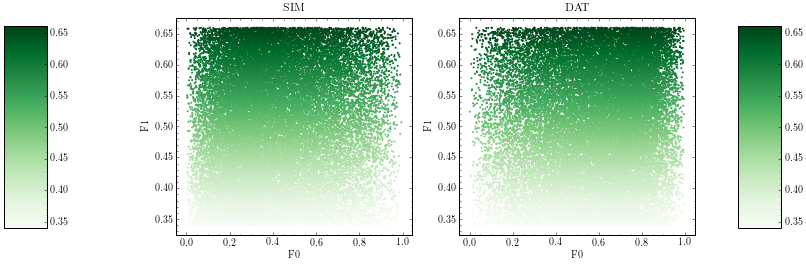

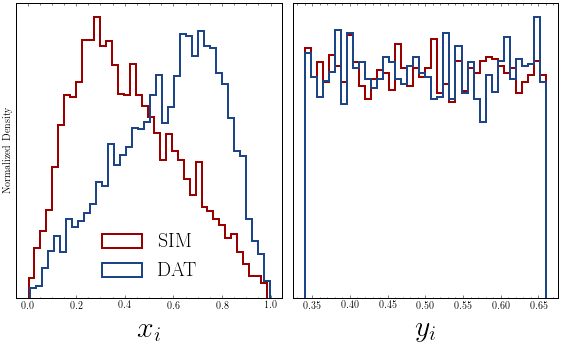

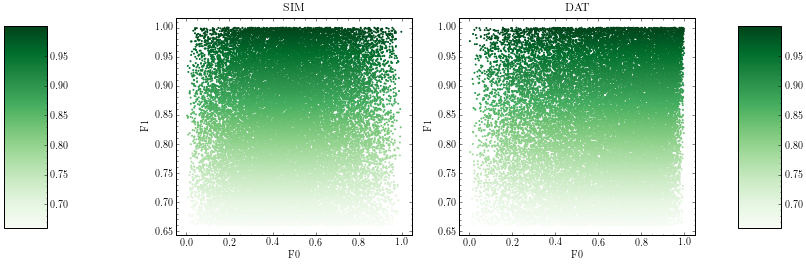

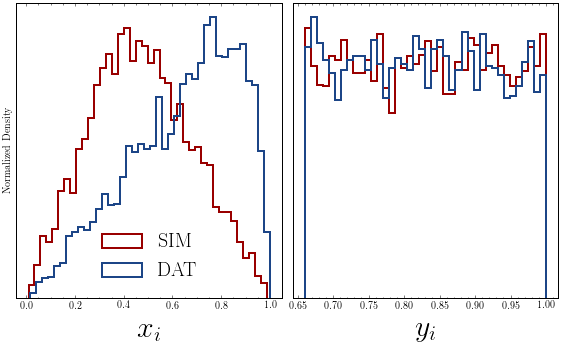

In [11]:
for band in ["sb1", "sr", "sb2"]:
    
    print(band)

    trial_data_sim = pull_from_mass_range(data_sim, [bands_dict[band]])
    trial_data_dat = pull_from_mass_range(data_dat, [bands_dict[band]])

    print(f"SIM {band} shape:", trial_data_sim.shape)
    print(f"DAT {band} shape:", trial_data_dat.shape)

    fig = scatterplot_features(trial_data_sim, trial_data_dat, bins, n_features, feature_labels, n_plot = -1, pointsize = 1)
    fig.show()


    fig = plot_feature_histograms(trial_data_sim, trial_data_dat, bins, n_features, feature_labels, n_plot = n_plot)
    fig.show()


## Pull SB1 and SB2

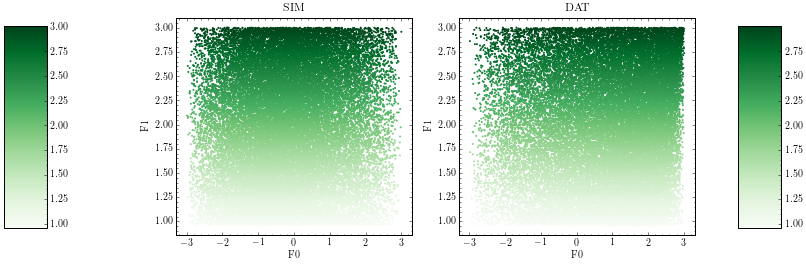

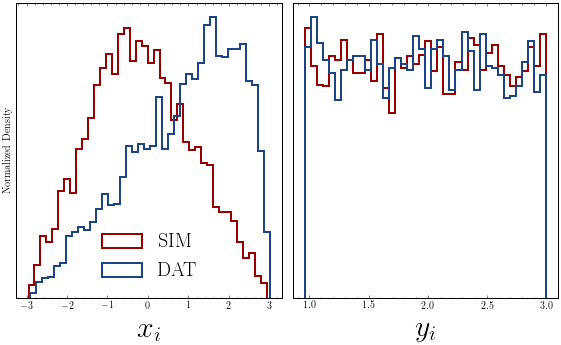

In [12]:
# try with minmaxscaling

trial_data_sim_mms = minmaxscale(trial_data_sim, col_minmax)
trial_data_dat_mms = minmaxscale(trial_data_dat, col_minmax)

fig = scatterplot_features(trial_data_sim_mms, trial_data_dat_mms, bins, n_features, feature_labels, n_plot = -1, pointsize = 1)
fig.show()

fig = plot_feature_histograms(trial_data_sim_mms, trial_data_dat_mms, bins, n_features, feature_labels, n_plot = n_plot)
fig.show()


## Generate datasets for flow training

In [13]:
train_sim = pull_from_mass_range(data_sim, [bands_dict["sb1"], bands_dict["sr"], bands_dict["sb2"]])
train_dat = pull_from_mass_range(data_dat, [bands_dict["sb1"], bands_dict["sb2"]])

sim_train, sim_val = train_test_split(train_sim, test_size=0.2, random_state=42)
dat_train, dat_val = train_test_split(train_dat, test_size=0.2, random_state=42)

In [14]:

# save
np.save(os.path.join(data_dir, "train_sim.npy"), sim_train)
np.save(os.path.join(data_dir, "val_sim.npy"), sim_val)
np.save(os.path.join(data_dir, "train_dat.npy"), dat_train)
np.save(os.path.join(data_dir, "val_dat.npy"), dat_val)


# prepare the classifier traininf
sr_sim = pull_from_mass_range(data_sim, [bands_dict["sr"]])
sr_dat = pull_from_mass_range(data_dat, [bands_dict["sr"]])
print(sr_sim.shape,sr_dat.shape )


np.save(os.path.join(data_dir, "classif_train_sim.npy"), sr_sim)
np.save(os.path.join(data_dir, "classif_train_dat.npy"), sr_dat)




(32084, 2) (31998, 2)
